# KNN Imputation 

**Definition**
- Replace missing data with the average of k-nearest neighbors
- k-nearest neighbors are determined based on the distance (e.g. Euclidean) using other variables that have values
- Choosing k is important. Too high k will include observations that are significantly different, too low k will be susceptible to outliers and noise. 

**Advantages**
- Estimate missing data more accurately with enough number of complete observations  
- Use correlation structure of the data 

**Limitations**
- Depedent on the availability/quality of other data variables

**References**
- [Secondary Analysis of Electronic Health Records](https://link.springer.com/chapter/10.1007/978-3-319-43742-2_13)



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# Read data

In [2]:
df = pd.read_csv('../data/house_price/train.csv')

In [3]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


# Explore data

In [4]:
numerical_columns = df.drop('SalePrice', axis=1).select_dtypes(np.number).columns
numerical_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [5]:
categorical_columns = df.select_dtypes('object').columns
categorical_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [6]:
# columns with null data 
numerical_null = numerical_columns[df[numerical_columns].isnull().mean() > 0]
df[numerical_null].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

In [7]:
# columns with null data 
categorical_null = categorical_columns[df[categorical_columns].isnull().mean() > 0]
df[categorical_null].isnull().mean()

Alley           0.937671
MasVnrType      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

# Split data

In [8]:
# test with LotFrontage and LotArea that we know have a high correlation 

X_train, X_test, y_train, y_test = train_test_split(df[['LotFrontage', 'LotArea']],
                                                    df['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((1022, 2), (438, 2))

# KNN Imputer

In [9]:
imputer = KNNImputer()
imputer.fit(X_train)

KNNImputer()

In [10]:
X_train_imputed = imputer.transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)

In [11]:
X_train_imputed

,LotFrontage,LotArea
0,84.0,9375.0
1,34.8,2887.0
2,50.0,7207.0
3,60.0,9060.0
4,60.0,8400.0
...,...,...
1017,82.0,9430.0
1018,60.0,9600.0
1019,68.0,8930.0
1020,43.0,3196.0


# Check imputed data 

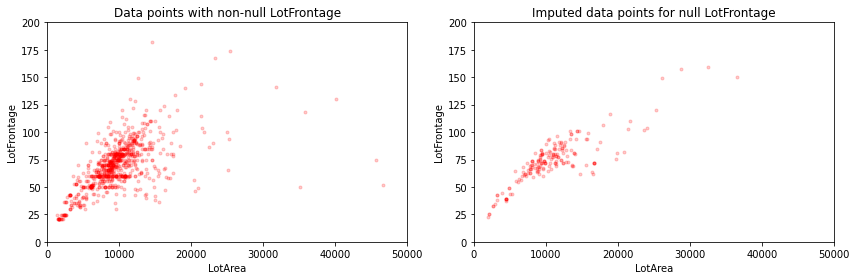

In [12]:
xmax = 50000 #X_train['LotArea'].max()*1.1
ymax = 200 #X_train['LotFrontage'].max()*1.1

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot 1: original relationship between LotFrontage and LotArea when LotFrontage is not null
ax = plt.subplot(1, 2, 1)
plt.plot(X_train[X_train['LotFrontage'].notna()]['LotArea'], 
         X_train[X_train['LotFrontage'].notna()]['LotFrontage'], '.r', alpha=0.2)
ax.set_xlim([0, xmax])
ax.set_ylim([0, ymax])
ax.set_xlabel('LotArea')
ax.set_ylabel('LotFrontage')
ax.set_title('Data points with non-null LotFrontage')

# plot 2: relationship between LotFrontage and LotArea for imputed data 
ax = plt.subplot(1, 2, 2)
plt.plot(X_train_imputed[X_train['LotFrontage'].reset_index(drop=True).isnull()]['LotArea'], 
         X_train_imputed[X_train['LotFrontage'].reset_index(drop=True).isnull()]['LotFrontage'], '.r', alpha=0.2)
ax.set_xlim([0, xmax])
ax.set_ylim([0, ymax])
ax.set_xlabel('LotArea')
ax.set_ylabel('LotFrontage')
ax.set_title('Imputed data points for null LotFrontage')

plt.tight_layout()
plt.show()

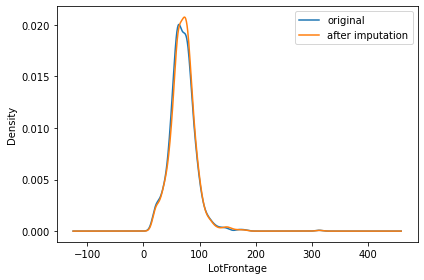

In [13]:
# compare the distribution 

fig, ax = plt.subplots()

X_train['LotFrontage'].plot(kind='kde')
X_train_imputed['LotFrontage'].plot(kind='kde')
ax.set_xlabel('LotFrontage')
plt.legend(['original', 'after imputation'])

plt.tight_layout()
plt.show()